In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from collections import Counter
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, confusion_matrix

2025-04-15 11:19:12.881460: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-15 11:19:12.883165: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-15 11:19:12.892194: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-15 11:19:12.914209: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744705152.964193   63046 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744705152.98

In [17]:
train_dir = '../dataset/train'
train_files = glob(os.path.join(train_dir, '*.png'))

train_df = pd.DataFrame({
    'filename': [os.path.basename(f) for f in train_files],
    'class': [f.split('_')[-1].split('.')[0] for f in train_files]
})
train_df['class'] = train_df['class'].astype(str)

In [ ]:
sns.countplot(x='class', data=train_df)
plt.title("Class Distribution")
plt.show()

In [26]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=(0.7, 1.3),
    validation_split=0.2
)

train_gen = datagen.flow_from_dataframe(
    train_df,
    directory=train_dir,
    x_col='filename',
    y_col='class',
    subset='training',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_gen = datagen.flow_from_dataframe(
    train_df,
    directory=train_dir,
    x_col='filename',
    y_col='class',
    subset='validation',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 1440 validated image filenames belonging to 2 classes.
Found 360 validated image filenames belonging to 2 classes.


In [19]:
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['class']),
    y=train_df['class']
)
class_weights = {i: weights[i] for i in range(len(weights))}

In [28]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
out = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=out)

model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [29]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    class_weight=class_weights,
    callbacks=callbacks
)

/home/pavlo/Work/Test_tasks/IT-Jim_TT/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8220 - loss: 0.8943 - val_accuracy: 0.7889 - val_loss: 0.4838
Epoch 2/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.6786 - loss: 0.7021 - val_accuracy: 0.6583 - val_loss: 0.6441
Epoch 3/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.5923 - loss: 0.6958 - val_accuracy: 0.6806 - val_loss: 0.6130
Epoch 4/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.6614 - loss: 0.6185 - val_accuracy: 0.7000 - val_loss: 0.6073
Epoch 5/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.6323 - loss: 0.7311 - val_accuracy: 0.6611 - val_loss: 0.6055


In [30]:
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.6302 - loss: 0.6908 - val_accuracy: 0.8222 - val_loss: 0.4130
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.6022 - loss: 0.6816 - val_accuracy: 0.8722 - val_loss: 0.3498
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.6527 - loss: 0.5769 - val_accuracy: 0.8861 - val_loss: 0.3295
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.6710 - loss: 0.5375 - val_accuracy: 0.8861 - val_loss: 0.3018
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.6925 - loss: 0.5189 - val_accuracy: 0.9028 - val_loss: 0.3061
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.6959 - loss: 0.4694 - val_accuracy: 0.9028 - val_loss: 0.2726
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.7375 - loss: 0.4828 - val_accuracy: 0.9278 - val_loss: 0.2631
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.7486 - loss: 0.4391 - val_accuracy: 0.9222 - val_lo

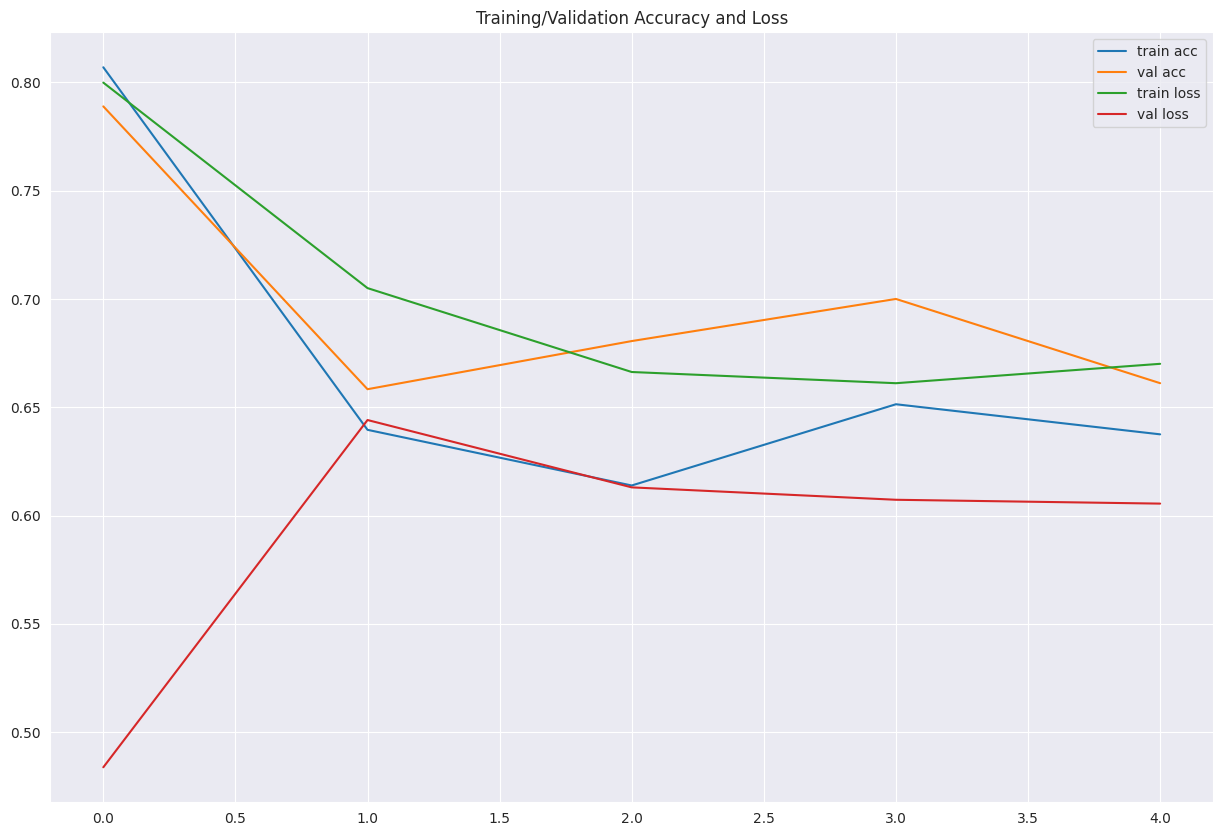

In [37]:
plt.figure(figsize=(15, 10))
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Training/Validation Accuracy and Loss')
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step
Micro F1 score: 0.9055555555555556


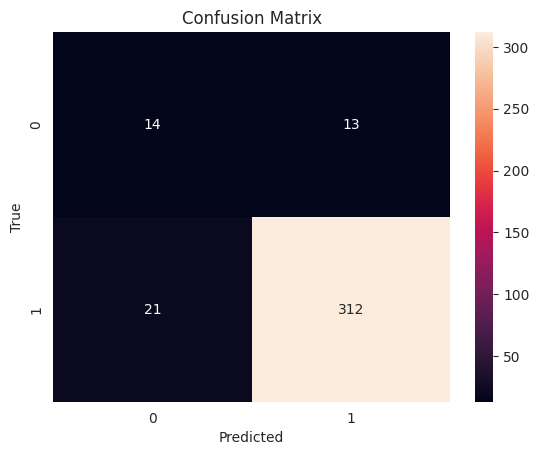

In [35]:
preds = model.predict(val_gen)
preds = (preds > 0.5).astype(int)
y_true = val_gen.classes

f1_micro = f1_score(y_true, preds, average='micro')
print("Micro F1 score:", f1_micro)

cm = confusion_matrix(y_true, preds)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [38]:
os.makedirs("../outputs/models", exist_ok=True)
model.save("../outputs/models/baseline_finetuned_mobilenetv2.h5")